# Classification with Tabular Data (Cognitive Tests and Demographics)

In [8]:
# !rm -r /content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src.egg-info
# !python3 -m pip install -e /content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/.

In [9]:
!pip install pycaret

     |████████████████████████████████| 266kB 12.2MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 1.7MB 22.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 174kB 56.0MB/s 
     |████████████████████████████████| 14.2MB 44.6MB/s 
     |████████████████████████████████| 1.4MB 56.8MB/s 
     |████████████████████████████████| 112kB 69.1MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 276kB 69.8MB/s 
     |████████████████████████████████| 256kB 43.6MB/s 
     |████████████████████████████████| 2.0MB 44.9MB/s 
     |████████████████████████████████| 6.8MB 17.5MB/s 
     |████████████████████████████████| 174kB 59.7MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 61kB 5.8MB

In [10]:
pip install interpret

     |████████████████████████████████| 5.8MB 15.4MB/s 
     |████████████████████████████████| 5.6MB 54.5MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 1.8MB 44.9MB/s 
     |████████████████████████████████| 3.6MB 43.1MB/s 
     |████████████████████████████████| 296kB 67.9MB/s 
     |████████████████████████████████| 276kB 56.0MB/s 
     |████████████████████████████████| 788kB 50.7MB/s 
     |████████████████████████████████| 122kB 57.3MB/s 
     |████████████████████████████████| 860kB 42.9MB/s 
     |████████████████████████████████| 358kB 55.5MB/s 
     |████████████████████████████████| 256kB 63.5MB/s 
     |████████████████████████████████| 1.0MB 38.7MB/s 
     |████████████████████████████████| 3.5MB 42.4MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 368kB 64.2MB/s 
     |████████████████████████████████| 358kB 54.5MB/s 
  Created wheel for dash: filename=dash-1.20.0-cp37-

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp
from joblib import dump, load
from collections import namedtuple

%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
%load_ext autoreload
%autoreload 2

from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis')

Mounted at /content/gdrive


In [4]:
# from src.model_training.mri_train_test_split import train_test_split_by_subject
from pycaret.utils import enable_colab
from pycaret.classification import *
from sklearn.metrics import fbeta_score,make_scorer

from interpret.glassbox import ExplainableBoostingClassifier
enable_colab()

Colab mode enabled.


In [5]:
os.chdir('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/src/')
from data_preparation.stratified_fold_split import *
from data_preparation.train_test_split import *

# ML Experimentation - Demographics + Cognitive Tests

## Base Code

### Experiment code

In [6]:

def run_tabular_data_experiment(df_adni_merge,
                                experiment_name,
                                labels = [0,1],
                                label_column = 'DIAGNOSIS',
                                n_splits = 5,
                                selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()]):
  print("Setting up experiment...")

  base_experiment_params = {
    'categorical_features': ['MALE','HISPANIC','RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN','MARRIED', 'WIDOWED', 'DIVORCED', 'NEVER_MARRIED'],
    'numeric_features': ['AGE','YEARS_EDUCATION','CDRSB', 'ADAS11','ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning','RAVLT_forgetting', 'RAVLT_perc_forgetting', 'TRABSCOR', 'FAQ', 'MOCA'],
    'target' : label_column,
    'transformation':True,
    'remove_multicollinearity' : False,
    'session_id':1,
    'silent':True,
    'verbose':0
  }

  df_train, df_test = train_test_split_by_subject(df_adni_merge,test_size=0.2,label_column=label_column,labels=labels)
  base_experiment_params['data'] = df_train.drop(["SUBJECT",'DIAGNOSIS_BASELINE'],axis=1)
  base_experiment_params['test_data'] = df_test.drop(["SUBJECT",'DIAGNOSIS_BASELINE'],axis=1)
  base_experiment_params['fold_strategy'] = StratifiedSubjectKFold(df_train,labels=labels,n_splits=n_splits,label_column=label_column)
  base_experiment_params['experiment_name'] = experiment_name
  exp_clinical = setup(**base_experiment_params)

  print("Training models...")
  trained_models = compare_models(include=selected_models,sort='AUC',n_select = 5,turbo=True,cross_validation = True,verbose=0)
  print("Models trained and validated!")
  print('-----------------------------------------------------')
  df_validation_results = pull().drop(['Kappa','MCC'],axis=1)
  print("Validation results: \n",df_validation_results)
  print('-----------------------------------------------------')
  df_test_results = []
  for model in trained_models:
    predict_model(model,verbose=0);
    test_performance = pull();
    df_test_results.append(test_performance)
  df_test_results = pd.concat(df_test_results).reset_index(drop=True).drop(['Kappa','MCC'],axis=1).sort_values('AUC',ascending=False)
  
  print("Test results: \n",df_test_results)
  print('-----------------------------------------------------')

  return df_validation_results,df_test_results,trained_models

## Data prep

In [4]:
df_adni_merge = pd.read_csv("/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/data/tabular/COGNITIVE_DATA_PROCESSED.csv")
organized_cols = ['SUBJECT','DIAGNOSIS','DIAGNOSIS_BASELINE','AGE', 'MALE', 'YEARS_EDUCATION', 'HISPANIC',
'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'MARRIED','WIDOWED','DIVORCED','NEVER_MARRIED', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
'RAVLT_perc_forgetting', 'TRABSCOR', 'FAQ', 'MOCA']
df_adni_merge = df_adni_merge[organized_cols]
df_adni_merge = df_adni_merge.dropna()
df_adni_merge.reset_index(drop=True,inplace=True)
df_adni_merge.shape


(6210, 26)

In [5]:
df_adni_merge['DIAGNOSIS_BASELINE'].value_counts()

MCI    3289
CN     2510
AD      411
Name: DIAGNOSIS_BASELINE, dtype: int64

In [6]:
df_adni_merge['DIAGNOSIS'].value_counts()

2    2902
0    2411
1     897
Name: DIAGNOSIS, dtype: int64

In [7]:
experiment_name = 'kkkkk'
labels = [0,1]
label_column = 'DIAGNOSIS'
n_splits = 5
selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()]

base_experiment_params = {
  'categorical_features': ['MALE','HISPANIC','RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN','MARRIED', 'WIDOWED', 'DIVORCED', 'NEVER_MARRIED'],
  'numeric_features': ['AGE','YEARS_EDUCATION','CDRSB', 'ADAS11','ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning','RAVLT_forgetting', 'RAVLT_perc_forgetting', 'TRABSCOR', 'FAQ', 'MOCA'],
  'target' : label_column,
  'transformation':True,
  'remove_multicollinearity' : False,
  'session_id':1,
  'silent':True,
  'verbose':0
}

df_train, df_test = train_test_split_by_subject(df_adni_merge,test_size=0.2,label_column=label_column,labels=labels)
base_experiment_params['data'] = df_train.drop(["SUBJECT",'DIAGNOSIS_BASELINE'],axis=1)
base_experiment_params['test_data'] = df_test.drop(["SUBJECT",'DIAGNOSIS_BASELINE'],axis=1)
base_experiment_params['fold_strategy'] = StratifiedSubjectKFold(df_train,labels=labels,n_splits=n_splits,label_column=label_column)
base_experiment_params['experiment_name'] = experiment_name

## CN vs AD

In [ ]:
df_validation_results_cnad, df_test_results_cnad,cnad_trained_models = run_tabular_data_experiment(df_adni_merge,experiment_name = 'cn_ad',labels = [0,1],label_column = 'DIAGNOSIS',n_splits = 5,selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()])

Setting up experiment...
Training models...
Models trained and validated!
-----------------------------------------------------
Validation results: 
                              Model  Accuracy     AUC  ...   Prec.      F1  TT (Sec)
4    ExplainableBoostingClassifier    0.9952  0.9997  ...  0.9943  0.9909     6.058
0              Logistic Regression    0.9944  0.9996  ...  0.9916  0.9895     0.046
2  Light Gradient Boosting Machine    0.9944  0.9996  ...  0.9929  0.9895     0.110
3           Extra Trees Classifier    0.9951  0.9990  ...  0.9958  0.9909     0.374
1              SVM - Linear Kernel    0.9911  0.0000  ...  0.9885  0.9829     0.312

[5 rows x 7 columns]
-----------------------------------------------------
Test results: 
                              Model  Accuracy     AUC  Recall   Prec.      F1
2  Light Gradient Boosting Machine    0.9924  0.9998  0.9892  0.9840  0.9866
0    ExplainableBoostingClassifier    0.9939  0.9997  0.9946  0.9840  0.9893
3           Extra Trees

## MCI vs AD

In [ ]:
df_validation_results_mciad, df_test_results_mciad,mciad_trained_models = run_tabular_data_experiment(df_adni_merge,experiment_name = 'mci_ad',labels = [1,2],label_column = 'DIAGNOSIS',n_splits = 5,selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()])

Setting up experiment...
Training models...
Models trained and validated!
-----------------------------------------------------
Validation results: 
                              Model  Accuracy     AUC  ...   Prec.      F1  TT (Sec)
0              Logistic Regression    0.9267  0.9693  ...  0.9466  0.9522     0.064
2  Light Gradient Boosting Machine    0.9280  0.9675  ...  0.9453  0.9531     0.124
4    ExplainableBoostingClassifier    0.9301  0.9669  ...  0.9446  0.9546     4.020
3           Extra Trees Classifier    0.9317  0.9668  ...  0.9428  0.9559     0.412
1              SVM - Linear Kernel    0.9130  0.0000  ...  0.9378  0.9436     0.318

[5 rows x 7 columns]
-----------------------------------------------------
Test results: 
                              Model  Accuracy     AUC  Recall   Prec.      F1
0              Logistic Regression    0.9333  0.9789  0.9681  0.9463  0.9571
1  Light Gradient Boosting Machine    0.9347  0.9780  0.9699  0.9464  0.9580
2    ExplainableBoostin

## MCI vs CN

In [ ]:
df_validation_results_mcicn, df_test_results_mcicn,mcicn_trained_models = run_tabular_data_experiment(df_adni_merge,experiment_name = 'mci_cn',labels = [0,2],label_column = 'DIAGNOSIS',n_splits = 5,selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()])

Setting up experiment...
Training models...
Models trained and validated!
-----------------------------------------------------
Validation results: 
                              Model  Accuracy     AUC  ...   Prec.      F1  TT (Sec)
0              Logistic Regression    0.9034  0.9512  ...  0.9059  0.9140     0.072
3           Extra Trees Classifier    0.8958  0.9477  ...  0.8956  0.9077     0.466
2  Light Gradient Boosting Machine    0.8943  0.9476  ...  0.9024  0.9055     0.122
4    ExplainableBoostingClassifier    0.8989  0.9471  ...  0.9038  0.9098     7.776
1              SVM - Linear Kernel    0.8939  0.0000  ...  0.8899  0.9063     0.322

[5 rows x 7 columns]
-----------------------------------------------------
Test results: 
                              Model  Accuracy     AUC  Recall   Prec.      F1
0              Logistic Regression    0.9076  0.9613  0.9382  0.8836  0.9101
3    ExplainableBoostingClassifier    0.9105  0.9598  0.9440  0.8843  0.9132
1           Extra Trees

# MRI Reference Alignment

In [21]:
# df_reference = pd.read_csv("/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/data/mri/processed/coronal_67K_REFERENCE.csv")
# df_reference2 = pd.read_csv("/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/data/mri/processed/coronal_25K_REFERENCE.csv")

# df_reference['SKIP_IMAGE'] = False
# df_reference.loc[19250:22000,'SKIP_IMAGE'] = True

# df_reference_final = df_reference.drop(['MODALITY','FORMAT','DOWNLOADED','SUBJECT_ID'],axis=1)
# df_reference2['SKIP_IMAGE'] = False
# df_reference_final = pd.concat([df_reference_final,df_reference2])

# imgs_to_skip =  ['ADNI_041_S_5244_MR_MT1__GradWarp__N3m_Br_20130724134244341_S194520_I382256_coronal_53_rot_180.npz',
# 'ADNI_041_S_5244_MR_MT1__GradWarp__N3m_Br_20130724134244341_S194520_I382256_coronal_55_flip_horizonal.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_47_flip_horizonal.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_50_rot_90.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_50_flip_vertical.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_46_rot_90.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_54_rot_90.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_54_rot_180.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_55.npz',
# 'ADNI_041_S_5244_MR_MT1__GradWarp__N3m_Br_20130724134244341_S194520_I382256_coronal_53_flip_horizonal.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_46_rot_270.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_55_rot_90.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_53_rot_90.npz',
# 'ADNI_021_S_0343_MR_MPR__GradWarp__N3__Scaled_Br_20071219174234295_S30492_I85699_coronal_47_rot_180.npz']
# df_reference_final.loc[df_reference_final['IMAGE_PATH'].isin(imgs_to_skip),'SKIP_IMAGE'] = True

In [26]:
# df_reference_final['SKIP_IMAGE'].sum()

2785

In [25]:
# df_reference_final.to_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/data/mri/processed/' + 'REFERENCE.csv',index=False)

# Ensemble Data Alignment

In [87]:
df_mri_prediction_reference = pd.read_csv('/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/data/tabular/MRI_REFERENCE_PREDICTIONS_coronal_test_250.csv')

if 'Unnamed: 0' in df_mri_prediction_reference.columns:
    df_mri_prediction_reference.drop('Unnamed: 0',axis=1,inplace=True)
    
df_mri_prediction_reference = df_mri_prediction_reference[['SUBJECT','IMAGE_DATA_ID','IMAGE_PATH','DL_PREDICT_PROBA_coronal','DL_PREDICTION_coronal','DATASET_TYPE']]
df_mri_prediction_reference = df_mri_prediction_reference.query("IMAGE_PATH.str.contains('_coronal_50') and not(IMAGE_PATH.str.contains('flip')) and not(IMAGE_PATH.str.contains('_rot_'))",engine='python')
# df_mri_prediction_reference['IMAGE_PATH'].unique().shape
df_mri_prediction_reference = df_mri_prediction_reference[~(df_mri_prediction_reference['IMAGE_PATH'].duplicated(keep='last'))]
df_mri_prediction_reference = df_mri_prediction_reference.rename(columns={'IMAGE_DATA_ID':'IMAGEUID'})
df_mri_prediction_reference['IMAGEUID'] = df_mri_prediction_reference['IMAGEUID'].str.replace('I','').astype(np.int64)

In [88]:
df_train_reference = df_mri_prediction_reference.query("DATASET_TYPE == 'train'")
df_validation_reference = df_mri_prediction_reference.query("DATASET_TYPE == 'validation'")
df_test_reference = df_mri_prediction_reference.query("DATASET_TYPE == 'test'")

In [89]:
df_adni_merge = pd.read_csv("/content/gdrive/MyDrive/Lucas_Thimoteo/mmml-alzheimer-diagnosis/data/tabular/COGNITIVE_DATA_PROCESSED.csv")
organized_cols = ['SUBJECT','IMAGEUID','DIAGNOSIS','DIAGNOSIS_BASELINE','AGE', 'MALE', 'YEARS_EDUCATION', 'HISPANIC',
'RACE_WHITE', 'RACE_BLACK', 'RACE_ASIAN', 'MARRIED','WIDOWED','DIVORCED','NEVER_MARRIED', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
'RAVLT_perc_forgetting', 'TRABSCOR', 'FAQ', 'MOCA']
df_adni_merge = df_adni_merge[organized_cols]
df_adni_merge = df_adni_merge.dropna()
df_adni_merge.reset_index(drop=True,inplace=True)
df_adni_merge.shape

(6210, 27)

In [91]:
df_ensemble = pd.merge(df_adni_merge,df_mri_prediction_reference,on=['SUBJECT','IMAGEUID'],how='left')
df_ensemble

SUBJECT  IMAGEUID  DIAGNOSIS DIAGNOSIS_BASELINE   AGE  MALE  \
0     100_S_5280    788060          0                 CN  67.5     1   
1     100_S_5280    999999          0                 CN  67.5     1   
2     100_S_5280    389161          0                 CN  67.5     1   
3     082_S_5279    387866          0                 CN  68.5     1   
4     082_S_5278    999999          0                 CN  80.2     1   
...          ...       ...        ...                ...   ...   ...   
6205  027_S_6001    999999          2                 CN  72.0     0   
6206  027_S_6582    999999          0                 CN  67.1     1   
6207  027_S_6643    999999          2                MCI  56.4     1   
6208  168_S_6921    999999          1                 AD  76.5     1   
6209  016_S_6800    999999          1                MCI  87.5     0   

      YEARS_EDUCATION  HISPANIC  RACE_WHITE  RACE_BLACK  RACE_ASIAN  MARRIED  \
0                  16         0           0           1           0        0   
1                  16         0           0           1           0        0   
2                  16         0           0           1           0        0   
3                  20         0           1           0           0        1   
4                  19         0           1           0           0        0   
...               ...       ...         ...         ...         ...      ...   
6205               14         0           1           0           0        1   
6206               14         0           1           0           0        1   
6207               16         0           1           0           0        1   
6208               16         0           0           1           0        1   
6209               19         0           1           0           0        0   

      WIDOWED  DIVORCED  NEVER_MARRIED  CDRSB  ADAS11  ADAS13  ADASQ4  MMSE  \
0           0         0              1    0.0    2.00    3.00     1.0  30.0   
1           0         0              1    0.0    3.00    4.00     1.0  29.0   
2           0         0              1    0.0    3.00    5.00     1.0  30.0   
3           0         0              0    0.0    4.00    7.00     3.0  30.0   
4           0         0              1    0.0    3.00    6.00     2.0  30.0   
...       ...       ...            ...    ...     ...     ...     ...   ...   
6205        0         0              0    2.0   16.33   24.33     5.0  27.0   
6206        0         0              0    0.0   12.00   17.00     3.0  28.0   
6207        0         0              0    3.0   18.00   24.00     5.0  26.0   
6208        0         0              0    8.0   24.67   33.67     8.0  21.0   
6209        1         0              0   12.0   30.33   42.33     8.0  19.0   

      RAVLT_immediate  RAVLT_learning  RAVLT_forgetting  \
0                38.0             6.0               5.0   
1                54.0             6.0               2.0   
2                42.0             7.0               2.0   
3                61.0             6.0               3.0   
4                39.0             3.0               5.0   
...               ...             ...               ...   
6205             31.0             5.0               4.0   
6206             34.0             3.0               7.0   
6207             27.0             1.0               4.0   
6208             26.0             2.0               6.0   
6209             10.0             2.0               2.0   

      RAVLT_perc_forgetting  TRABSCOR   FAQ  MOCA  \
0                   50.0000      67.0   0.0  27.0   
1                   16.6667      66.0   0.0  24.0   
2                   20.0000      72.0   0.0  28.0   
3                   20.0000      40.0   0.0  27.0   
4                   55.5556      85.0   0.0  29.0   
...                     ...       ...   ...   ...   
6205                50.0000     300.0   1.0  18.0   
6206                87.5000      68.0   0.0  23.0   
6207                80.0000     114.0   8.0  21.

In [92]:
df_train_mri = df_mri_prediction_reference.query("DATASET_TYPE == 'train'")
df_validation_mri = df_mri_prediction_reference.query("DATASET_TYPE == 'validation'")
df_test_mri = df_mri_prediction_reference.query("DATASET_TYPE == 'test'")

In [160]:
df_not_mri = df_ensemble.query("DATASET_TYPE != DATASET_TYPE")
df_train = pd.concat([df_ensemble.query("DATASET_TYPE == 'train'"),df_ensemble.query("DATASET_TYPE != DATASET_TYPE").iloc[:4000]])
df_validation = pd.concat([df_ensemble.query("DATASET_TYPE == 'validation'"),df_ensemble.query("DATASET_TYPE != DATASET_TYPE").iloc[4000:5000]])
df_test = pd.concat([df_ensemble.query("DATASET_TYPE == 'test'"),df_ensemble.query("DATASET_TYPE != DATASET_TYPE").iloc[5000:]])

In [137]:
labels = [0,1]
label_column = 'DIAGNOSIS'
n_splits = 5
selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()]

# df_train, df_validation = train_test_split_by_subject(df_ensemble,test_size=0.2,label_column=label_column,labels=labels)
# df_train, df_test = train_test_split_by_subject(df_train,test_size=0.25,label_column=label_column,labels=labels)

In [138]:
# df_train = df_train.query("DATASET_TYPE == 'train' or DATASET_TYPE != DATASET_TYPE")
# train_subjects = df_train['IMAGEUID'].unique()
# df_train_final = df_ensemble.query("DATASET_TYPE == 'train' or IMAGEUID in @train_subjects")

# df_test = df_test.query("DATASET_TYPE == 'test' or DATASET_TYPE != DATASET_TYPE")
# test_subjects = df_test['IMAGEUID'].unique()
# df_test_final = df_ensemble.query("DATASET_TYPE == 'test' or IMAGEUID in @test_subjects")

# df_validation = df_validation.query("DATASET_TYPE == 'validation' or DATASET_TYPE != DATASET_TYPE")
# validation_subjects = df_validation['IMAGEUID'].unique()
# df_validation_final = df_ensemble.query("DATASET_TYPE == 'validation' or IMAGEUID in @validation_subjects")

In [161]:
labels = [0,1]
label_column = 'DIAGNOSIS'
n_splits = 5
selected_models = ['lr','svm','lightgbm','et',ExplainableBoostingClassifier()]

In [162]:
X_train = df_train.drop(['SUBJECT','IMAGEUID','DIAGNOSIS','DIAGNOSIS_BASELINE','IMAGE_PATH','DL_PREDICT_PROBA_coronal','DL_PREDICTION_coronal','DATASET_TYPE'],axis=1)
y_train = df_train['DIAGNOSIS']

X_validation = df_validation.drop(['SUBJECT','IMAGEUID','DIAGNOSIS','DIAGNOSIS_BASELINE','IMAGE_PATH','DL_PREDICT_PROBA_coronal','DL_PREDICTION_coronal','DATASET_TYPE'],axis=1)
y_validation = df_validation['DIAGNOSIS']

X_test = df_test.drop(['SUBJECT','IMAGEUID','DIAGNOSIS','DIAGNOSIS_BASELINE','IMAGE_PATH','DL_PREDICT_PROBA_coronal','DL_PREDICTION_coronal','DATASET_TYPE'],axis=1)
y_test = df_test['DIAGNOSIS']

In [163]:
ebm = ExplainableBoostingClassifier().fit(X_train,y_train)

In [164]:
df_train['COG_TEST_PREDICT_PROB'] = ebm.predict_proba(X_train)[:,-1]
df_validation['COG_TEST_PREDICT_PROB'] = ebm.predict_proba(X_validation)[:,-1]
df_test['COG_TEST_PREDICT_PROB'] = ebm.predict_proba(X_test)[:,-1]

In [169]:
df_train_ensemble = df_train.query("DL_PREDICT_PROBA_coronal == DL_PREDICT_PROBA_coronal")[['DIAGNOSIS','DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']]
df_validation_ensemble = df_validation.query("DL_PREDICT_PROBA_coronal == DL_PREDICT_PROBA_coronal")[['DIAGNOSIS','DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']]
df_test_ensemble = df_test.query("DL_PREDICT_PROBA_coronal == DL_PREDICT_PROBA_coronal")[['DIAGNOSIS','DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']]

In [171]:
threshold = 0.5

df_train_ensemble['MEAN_PROB'] = df_train_ensemble['DL_PREDICT_PROBA_coronal'] * df_train_ensemble['COG_TEST_PREDICT_PROB']
df_validation_ensemble['MEAN_PROB'] = df_validation_ensemble['DL_PREDICT_PROBA_coronal'] * df_validation_ensemble['COG_TEST_PREDICT_PROB']
df_test_ensemble['MEAN_PROB'] = df_test_ensemble['DL_PREDICT_PROBA_coronal'] * df_test_ensemble['COG_TEST_PREDICT_PROB']

df_train_ensemble['MEAN_RESULT'] = df_train_ensemble['MEAN_PROB'] >= threshold
df_validation_ensemble['MEAN_RESULT'] = df_validation_ensemble['MEAN_PROB'] >= threshold
df_test_ensemble['MEAN_RESULT'] = df_test_ensemble['MEAN_PROB'] >= threshold

In [172]:
ebm2 = ExplainableBoostingClassifier().fit(df_train_ensemble[['DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']],df_train_ensemble['DIAGNOSIS'])

In [173]:
df_train_ensemble['EBM_RESULT'] = ebm2.predict(df_train_ensemble[['DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']])
df_validation_ensemble['EBM_RESULT'] = ebm2.predict(df_validation_ensemble[['DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']])
df_test_ensemble['EBM_RESULT'] = ebm2.predict(df_test_ensemble[['DL_PREDICT_PROBA_coronal','COG_TEST_PREDICT_PROB']])

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,recall_score, classification_report, auc, roc_curve,roc_auc_score, fbeta_score

from interpret.glassbox import ExplainableBoostingClassifier

my_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
f1_scorer = make_scorer(fbeta_score, beta=1)

In [183]:
def plot_confusion_matrix(y_true,y_pred,labels = ['CN', 'AD'],dataset_type = 'TESTE'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    total_positives = y_true.sum()
    total_negatives = y_true.shape[0] - total_positives
    df_cf = pd.DataFrame(columns=['negatives','positives']) 
    df_cf['negatives'] = conf_matrix[0,:] / total_negatives
    df_cf['positives'] = conf_matrix[1,:] / total_positives
#     conf_matrix = df_cf.T.values
    plt.figure(figsize=(8, 8))
    sns.heatmap(df_cf.T.values, xticklabels=labels, yticklabels=labels, annot=True, annot_kws={"fontsize":18});
    plt.title('MATRIZ DE CONFUSÃO - Conjunto {0}'.format(dataset_type), fontsize = 20)
    plt.xlabel('CLASSE PREDITA')
    plt.ylabel('CLASSE VERDADEIRA')
    plt.show()
    return conf_matrix

In [221]:
def metrics_report(model_name,y_true,y_pred,conf_interval = '99%'):
    class_report = classification_report(y_true, y_pred,output_dict = True)
    
    metrics_dict = {
      'Accuracy' : class_report['accuracy'],
      'Recall' : class_report['macro avg']['recall'],
      'Precision' : class_report['macro avg']['precision'],
      'F1' : class_report['macro avg']['f1-score'],
      'F2' : fbeta_score(y_true, y_pred,beta = 2, average='macro'),
    }
    print('')
    print('Performance Report for ',model_name)

    # try:
    #     probs = model.predict_proba(X)
    #     probs = probs[:, 1]
    #     model_auc = roc_auc_score(y, probs)
    #     metrics_dict['AUC'] = model_auc
    # except:
    #     print('Could not calculate AUC...')
    

    n = y_pred.shape[0]
    # const = 2.58 if conf_interval == '99%' else 1.96 
    for name,value in metrics_dict.items():
      print(name + ": %1.3f" % value)
    print('')

# Early Report

In [176]:
print("Ensemble datasets:")
print('Train size',df_train_ensemble.shape)
print('Validation size',df_validation_ensemble.shape)
print('Test size',df_test_ensemble.shape)

Ensemble datasets:
Train size (165, 6)
Validation size (57, 6)
Test size (55, 6)


### Maiores Obstáculos:

- Divergência de informações
- Imagens baixadas não foram 100% sincronizadas com os dados tabulares
- Volume muito alto de dados
- Dropout variável na modelagem



Sugestões: 

- Olhar pesos da regressão logistica do ensemble
- Adicionar mais um corte
- Explica 


# Train set

In [189]:
df_train_ensemble.loc[df_train_ensemble['MEAN_RESULT'] == False,'MEAN_RESULT'] = 0
df_train_ensemble.loc[df_train_ensemble['MEAN_RESULT'] == True,'MEAN_RESULT'] = 1

df_validation_ensemble.loc[df_validation_ensemble['MEAN_RESULT'] == False,'MEAN_RESULT'] = 0
df_validation_ensemble.loc[df_validation_ensemble['MEAN_RESULT'] == True,'MEAN_RESULT'] = 1

df_test_ensemble.loc[df_test_ensemble['MEAN_RESULT'] == False,'MEAN_RESULT'] = 0
df_test_ensemble.loc[df_test_ensemble['MEAN_RESULT'] == True,'MEAN_RESULT'] = 1

In [217]:
y_true = df_test_ensemble['DIAGNOSIS'].astype(int).values
y_pred = df_test_ensemble['EBM_RESULT'].astype(int).values

In [ ]:
df_train_ensemble['DIAGNOSIS'].values,df_train_ensemble['MEAN_RESULT'].values

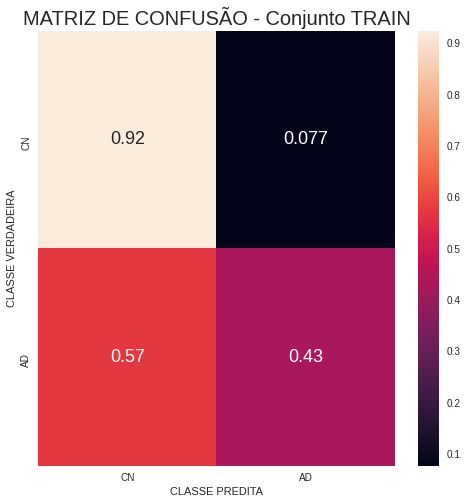

array([[36,  3],
       [ 8,  6]])

In [218]:
plot_confusion_matrix(y_true,y_pred,labels = ['CN', 'AD'],dataset_type = 'TRAIN')

In [222]:
metrics_report('Mean',y_true,y_pred,conf_interval = '99%')


Performance Report for  Mean
Accuracy: 0.792
Recall: 0.676
Precision: 0.742
F1: 0.695
F2: 0.681



In [197]:
df_train_ensemble = df_train_ensemble.query("DIAGNOSIS != 2")
df_validation_ensemble = df_validation_ensemble.query("DIAGNOSIS != 2")
df_test_ensemble = df_test_ensemble.query("DIAGNOSIS != 2")

In [200]:
df_train_ensemble['MEAN_RESULT'].value_counts()

0    155
1      8
Name: MEAN_RESULT, dtype: int64